In [1]:
import pandas as pd
import numpy as np

import json

from scripts.utils import SimulateData
from stopsignalmetrics.ssrtmodel import SSRTmodel

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Suffix
### Indicates which set of results to view

In [2]:
suffix = 'SSRTscale-0_RTscale-0'

# SSRT by SSD

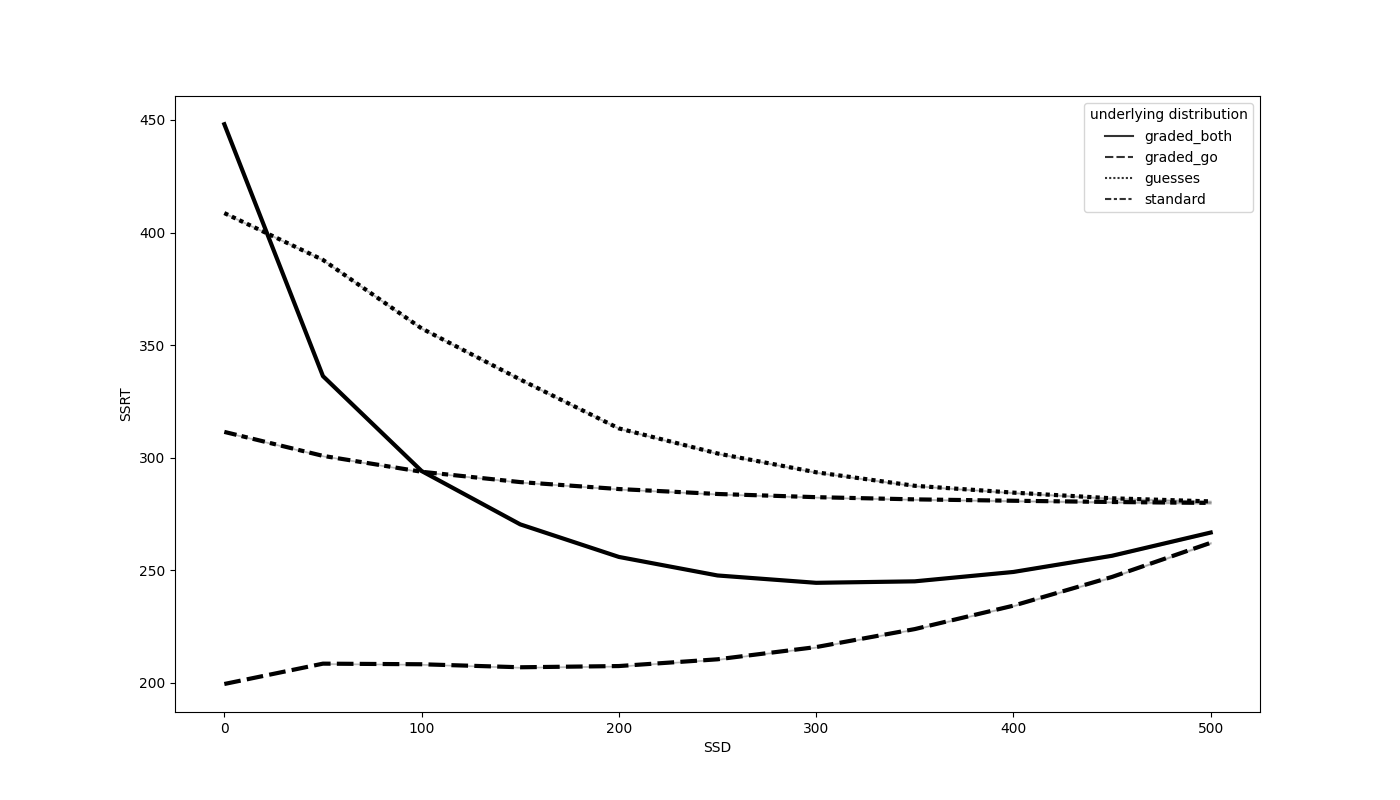

In [3]:
Image('figures/%s/SSRT_by_SSD.png' % suffix)

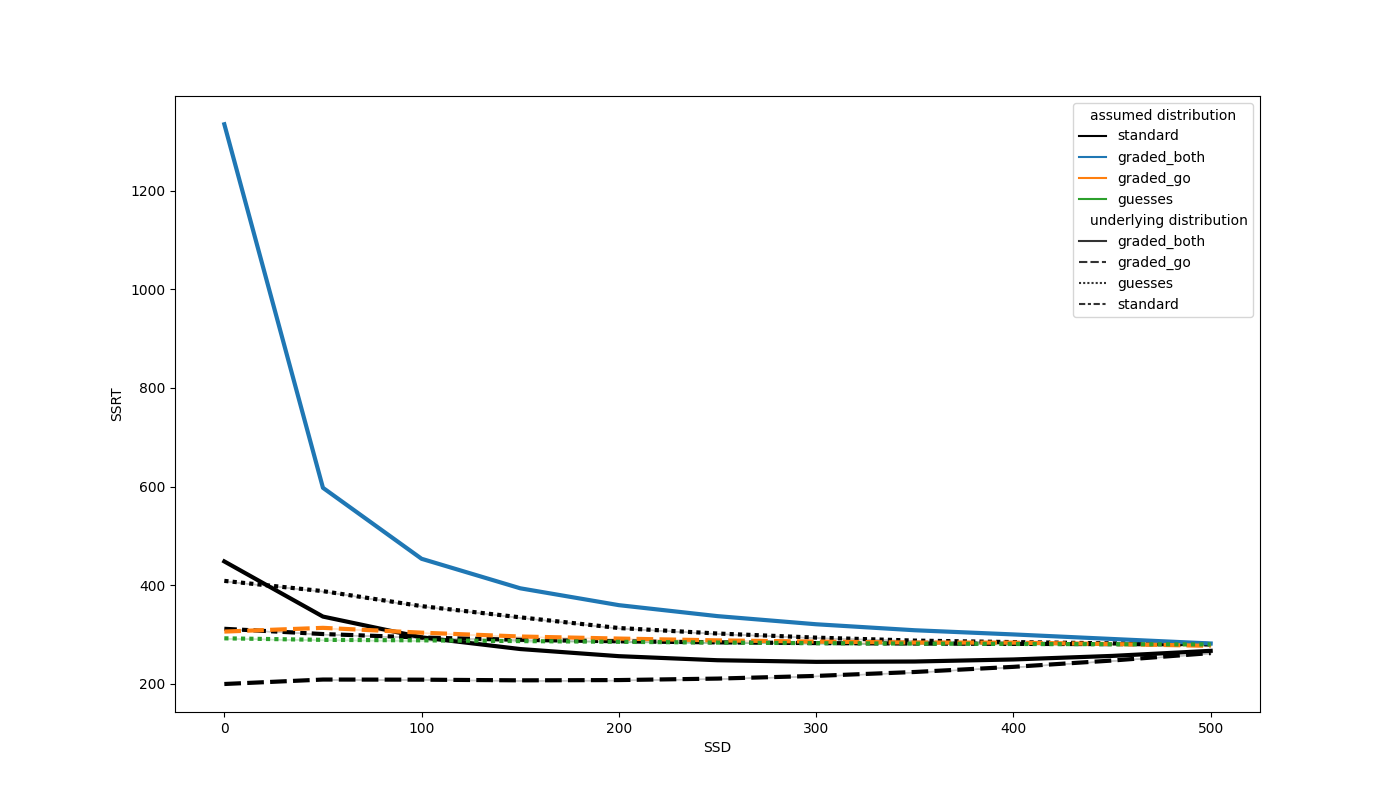

In [4]:
Image('figures/%s/SSRT_by_SSD_supplement.png' % suffix)

# Inhibition Function

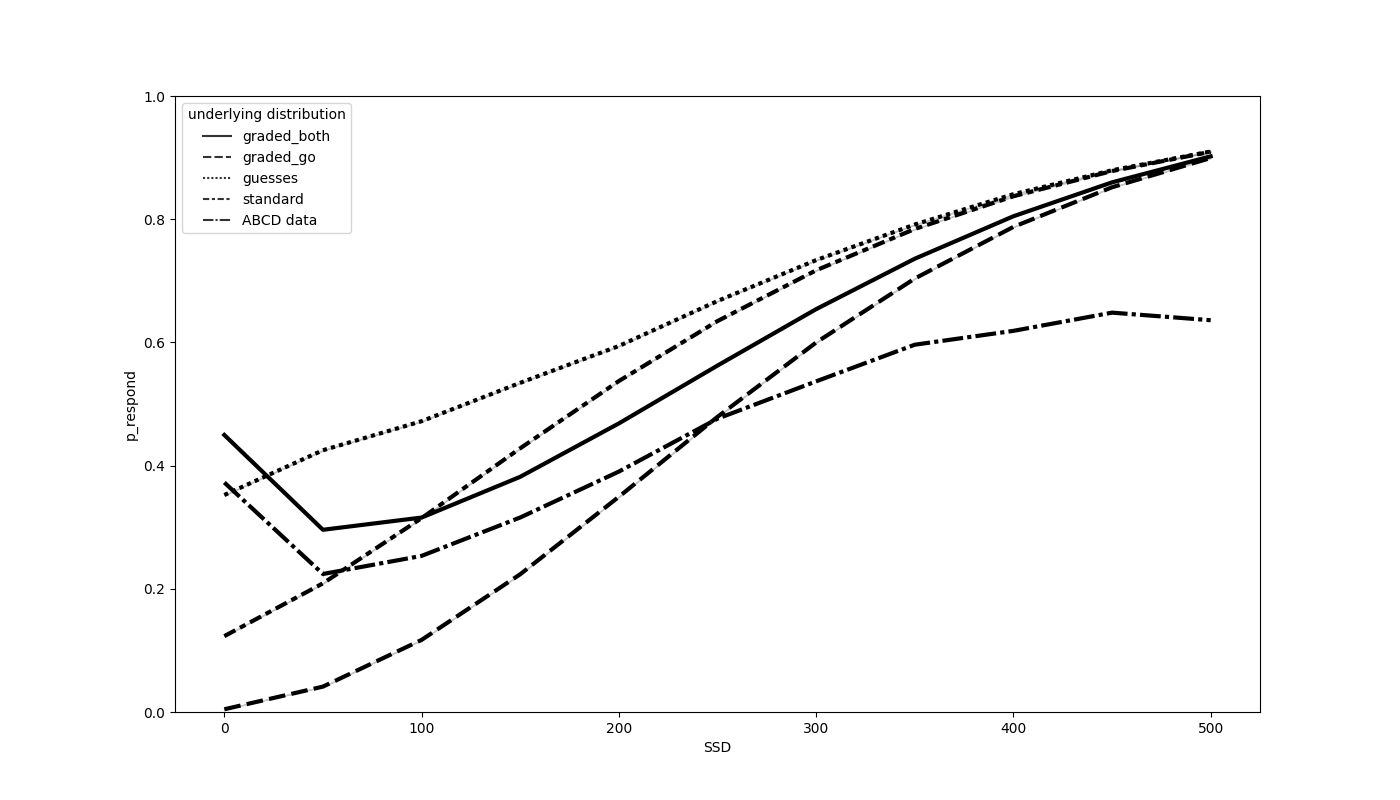

In [5]:
Image('figures/%s/inhibition_function.png' % suffix)

# Individual Differences

In [6]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

In [7]:
ssrt_df = pd.read_csv('ssrt_metrics/expected_ssrts_%s.csv' % suffix, index_col=0)

# reformatting - was multiindex
ssrt_df.columns = [ f'gen-{gen}_SSRT-{ssrt}' for gen, ssrt in zip(ssrt_df.loc['underlying distribution', :].values, ssrt_df.columns)]
ssrt_df = ssrt_df.drop(['underlying distribution', 'NARGUID'])

for col in ssrt_df.columns:
    ssrt_df[col] = ssrt_df[col].astype(float)


## **kludge** - Dask seems to have struggled reading a single tracking-based SSRT from a single subject's SSRT csv; only for the single individual case (SSRTscale-0_RTscale-0). I have downloaded the csv and am reading in the value to the expected_ssrts csv here.

In [8]:
#check the 3 other columns to make sure there is no instance
ok_tracking_ssrts = ['gen-graded_both_SSRT-tracking', 'gen-graded_go_SSRT-tracking.1', 'gen-standard_SSRT-tracking.3']
for ok_col in ok_tracking_ssrts:
    assert sum(ssrt_df[ok_col].isnull())==0
    
# checking problem sub
problem_ssrt_col = 'gen-guesses_SSRT-tracking.2'
problem_row = ssrt_df[ssrt_df[problem_ssrt_col].isnull()]
assert len(problem_row)==1
problem_sub = problem_row.index[0]
problem_sub

problem_sub_ssrt_df = pd.read_csv('ssrt_metrics/individual_metrics_SSRTscale-0_RTscale-0/guesses_%s.csv' % problem_sub, index_col=0)

# add back in value
ssrt_df.loc[problem_sub, problem_ssrt_col] = problem_sub_ssrt_df.loc[problem_sub_ssrt_df.SSD == np.inf, 'SSRT'].values[0]

#confirm kludge worked
assert sum(ssrt_df[problem_ssrt_col].isnull())==0

## Reading in assigned mus/ SSRTs and RTs for comparison

In [9]:
# getting expect SSRTs
mus_path = 'abcd_data/assigned_mus_%s.json' % suffix
with open(mus_path, 'r') as f:
    mus_dict = json.load(f)
    
mus_df = pd.DataFrame(mus_dict).T

In [10]:
mus_df.head()

,goRT,go,SSRT,stop
003RTV85,545.743782,0.201717,301.339962,0.397867
007W6H7B,545.743782,0.201717,301.339962,0.397867
00CY2MDM,545.743782,0.201717,301.339962,0.397867
00HEV6HB,545.743782,0.201717,301.339962,0.397867
00J52GPG,545.743782,0.201717,301.339962,0.397867


In [11]:
monster_df = pd.concat([mus_df.add_prefix('assigned_'), ssrt_df], 1, sort=True)
monster_df.columns = [col.split('.')[0] for col in monster_df.columns]
monster_df = monster_df.loc[monster_df['gen-standard_SSRT-fixed'].notnull()]

In [12]:
monster_df.shape

(8238, 28)

In [13]:
def make_plot_square(ax):
    lowx, highx = ax.get_xlim()
    lowy, highy = ax.get_ylim()
    low = min(lowx, lowy)
    high = max(highx, highy)
    ax.set_xlim((low, high))
    ax.set_ylim((low, high))
    return ax

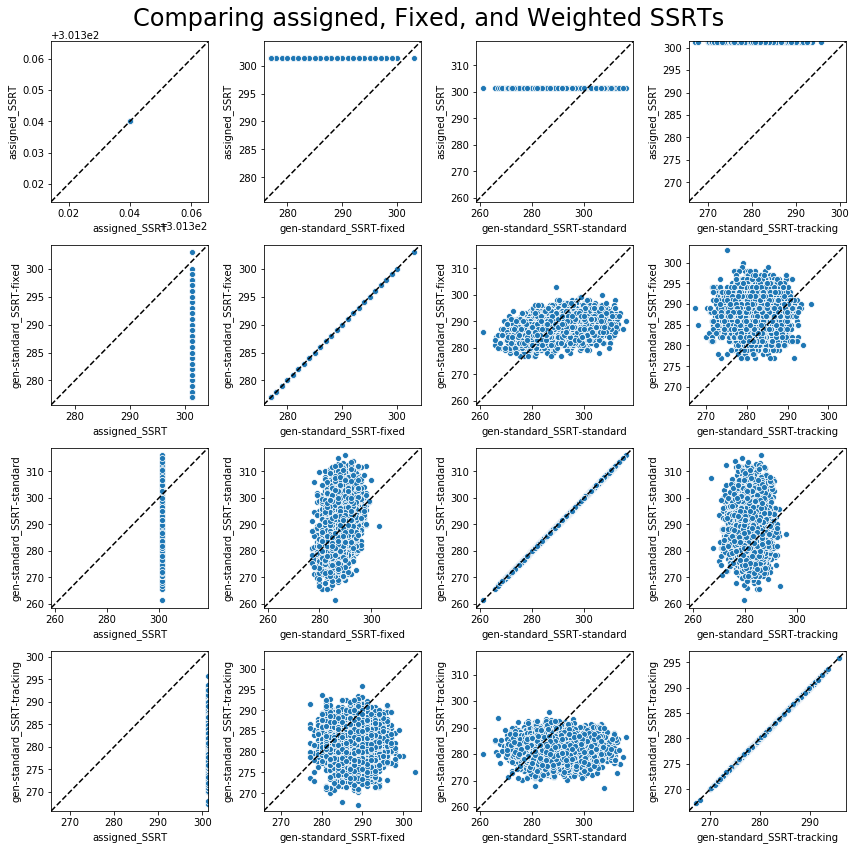

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

columns = ['assigned_SSRT', 'gen-standard_SSRT-fixed', 'gen-standard_SSRT-standard', 'gen-standard_SSRT-tracking']
for idx,coli in enumerate(columns):
    for jdx, colj in enumerate(columns):
        ax = sns.scatterplot(x=colj, y=coli, data=monster_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing assigned, Fixed, and Weighted SSRTs', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [15]:
monster_df[columns].corr(method='spearman')

,assigned_SSRT,gen-standard_SSRT-fixed,gen-standard_SSRT-standard,gen-standard_SSRT-tracking
assigned_SSRT,NaN,NaN,NaN,NaN
gen-standard_SSRT-fixed,NaN,1.000000,0.353255,-0.001971
gen-standard_SSRT-standard,NaN,0.353255,1.000000,0.007490
gen-standard_SSRT-tracking,NaN,-0.001971,0.007490,1.000000


# Comparing Fixed SSRTs

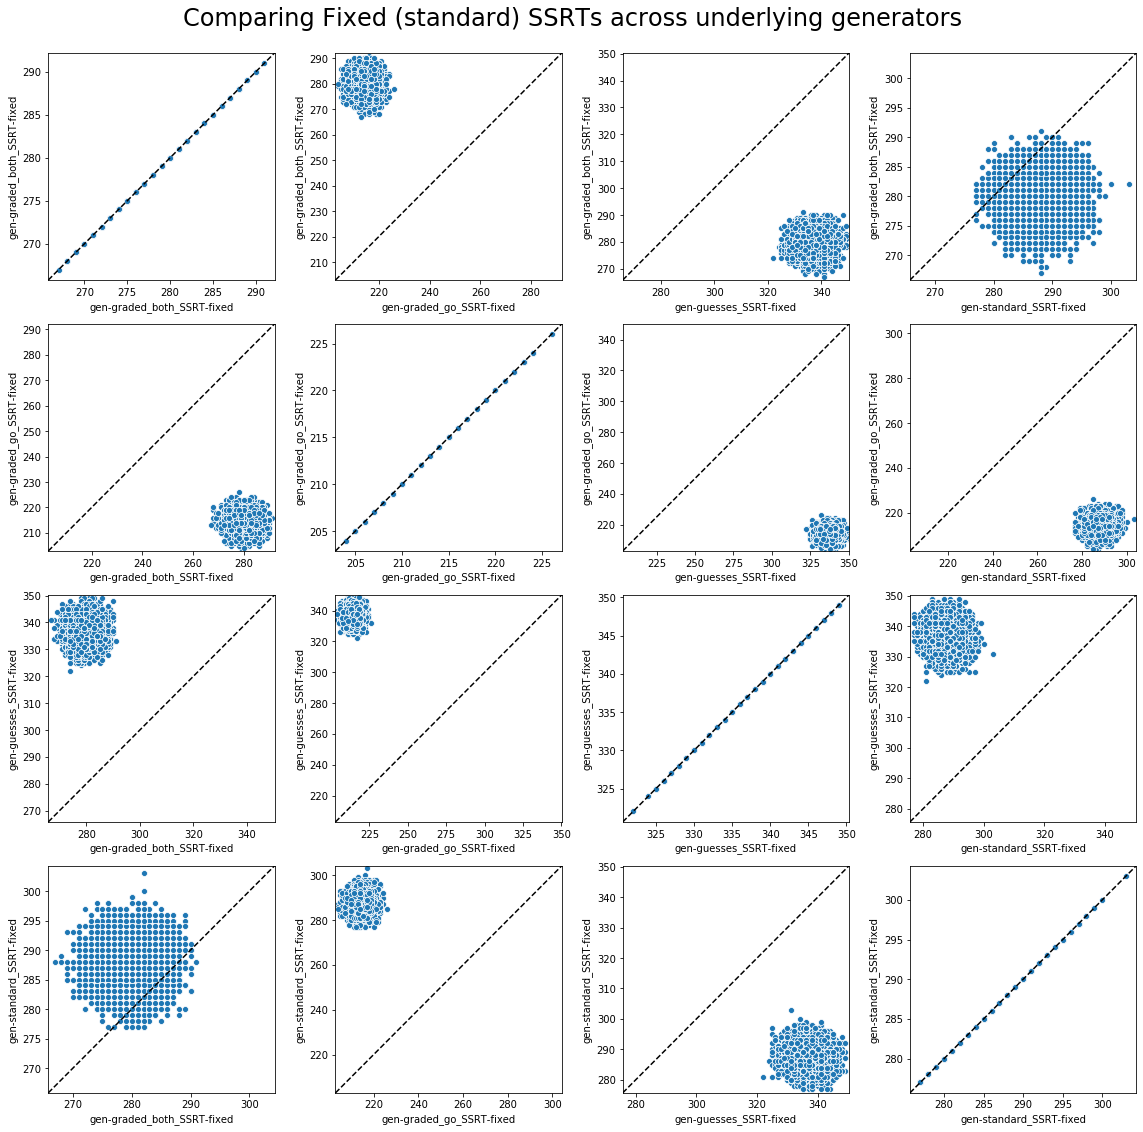

In [16]:
curr_df = monster_df.filter(regex='fixed')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [17]:
curr_df.corr(method='spearman')

,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed,gen-guesses_SSRT-fixed,gen-standard_SSRT-fixed
gen-graded_both_SSRT-fixed,1.000000,0.003772,0.017048,0.006882
gen-graded_go_SSRT-fixed,0.003772,1.000000,-0.005662,0.016220
gen-guesses_SSRT-fixed,0.017048,-0.005662,1.000000,0.011596
gen-standard_SSRT-fixed,0.006882,0.016220,0.011596,1.000000


## (not rescaling the axes to get a closer look)

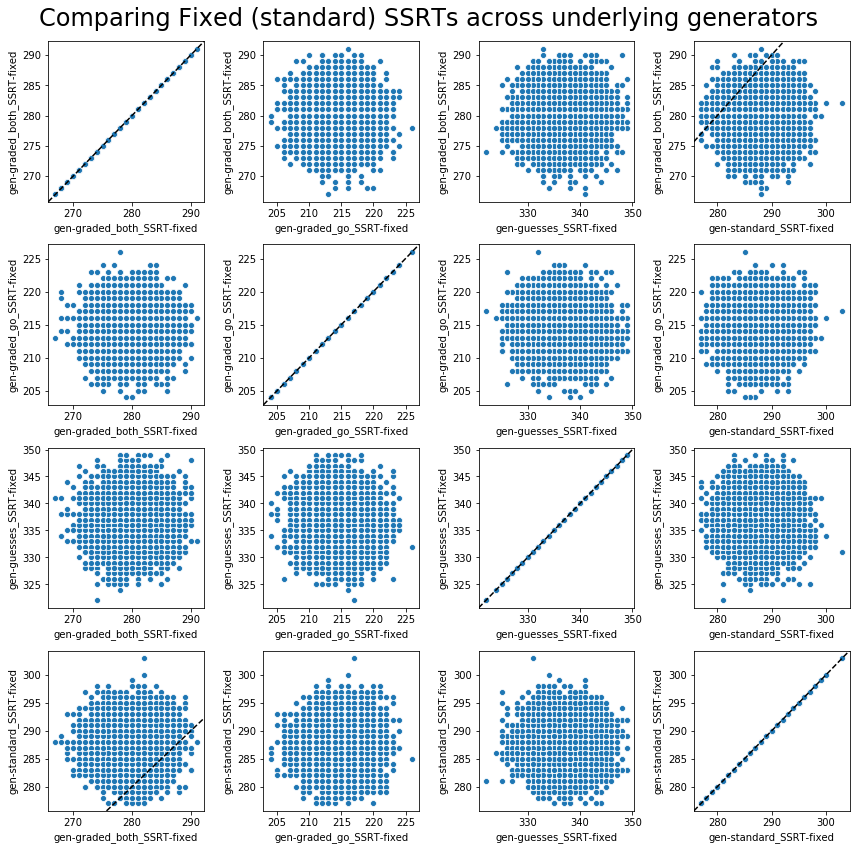

In [18]:
curr_df = monster_df.filter(regex='fixed')
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Fixed (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Weighted SSRTs (from randomly assigned SSD distributions)

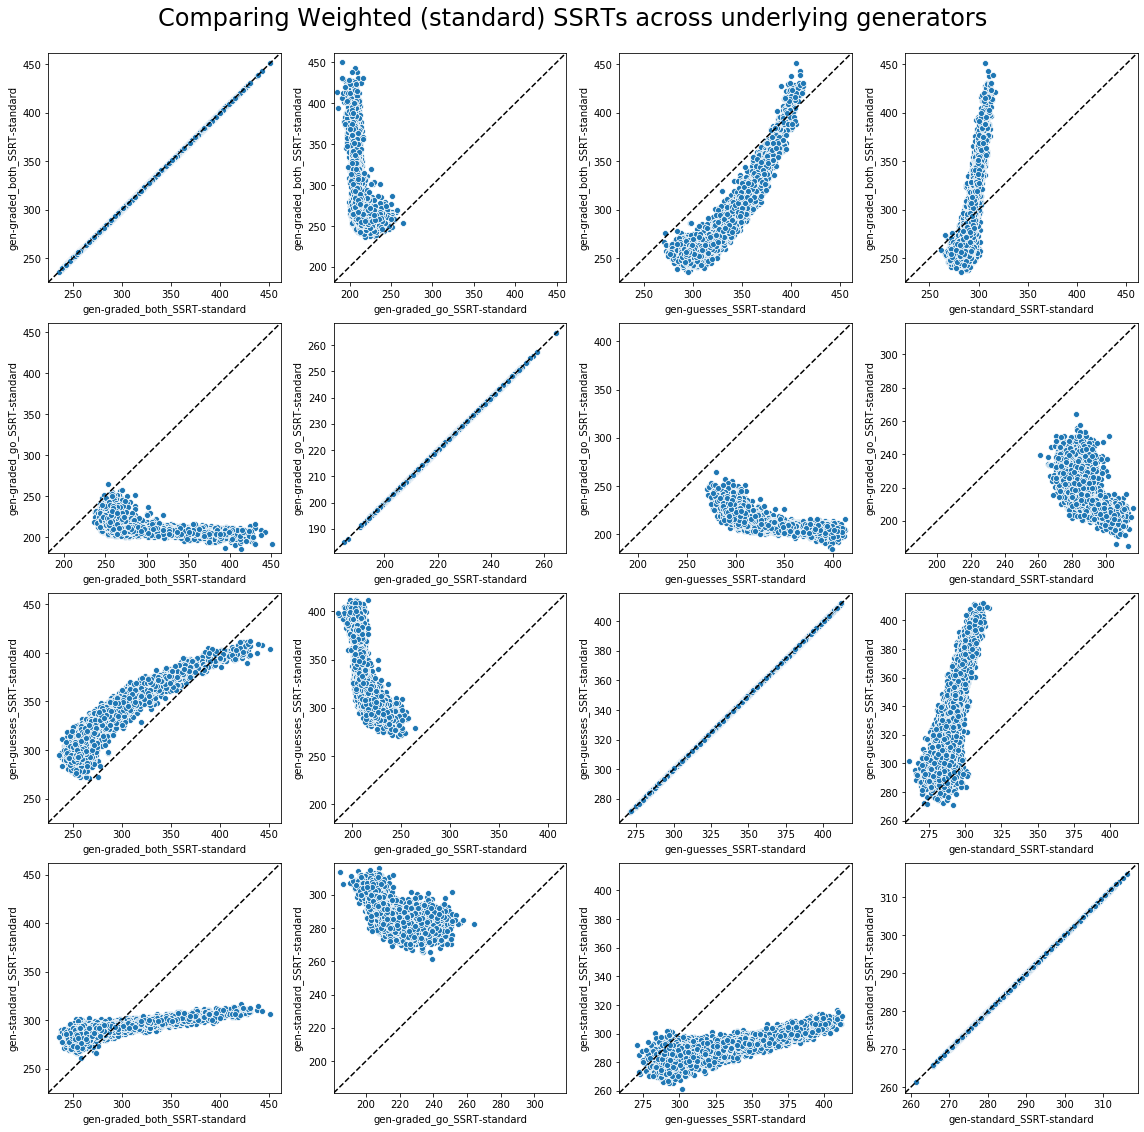

In [19]:
curr_df = monster_df.filter(regex='SSRT-standard')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [20]:
curr_df.corr(method='spearman')

,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard,gen-guesses_SSRT-standard,gen-standard_SSRT-standard
gen-graded_both_SSRT-standard,1.000000,-0.698377,0.880411,0.732705
gen-graded_go_SSRT-standard,-0.698377,1.000000,-0.844545,-0.641284
gen-guesses_SSRT-standard,0.880411,-0.844545,1.000000,0.753997
gen-standard_SSRT-standard,0.732705,-0.641284,0.753997,1.000000


## not rescaling axis to get a closer look

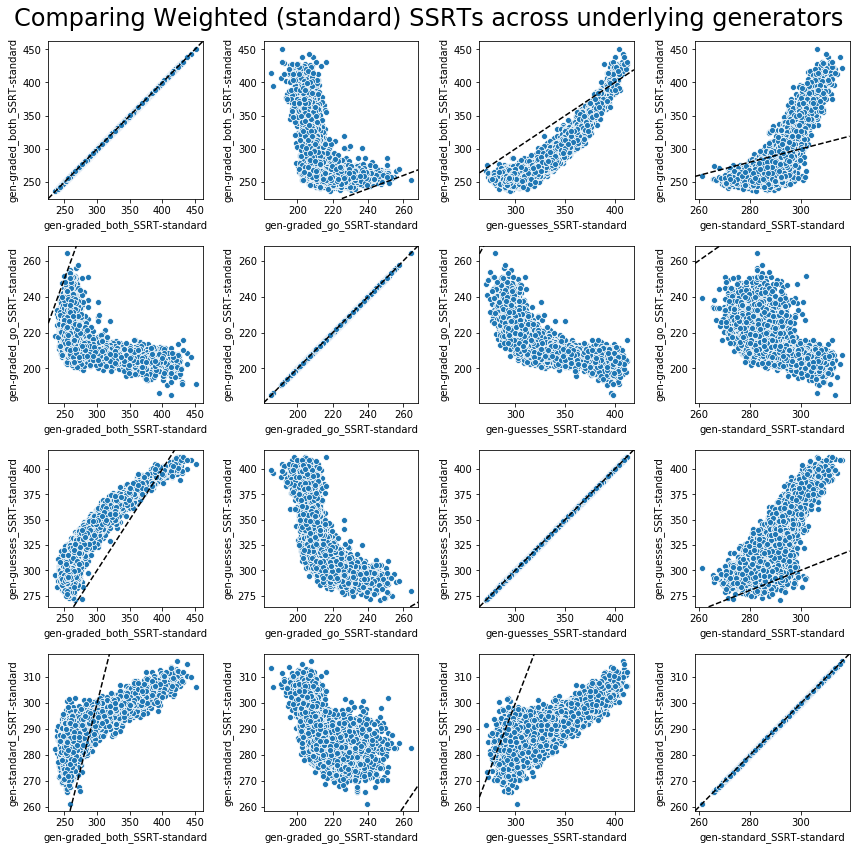

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Weighted (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

# Tracking-based SSRTs

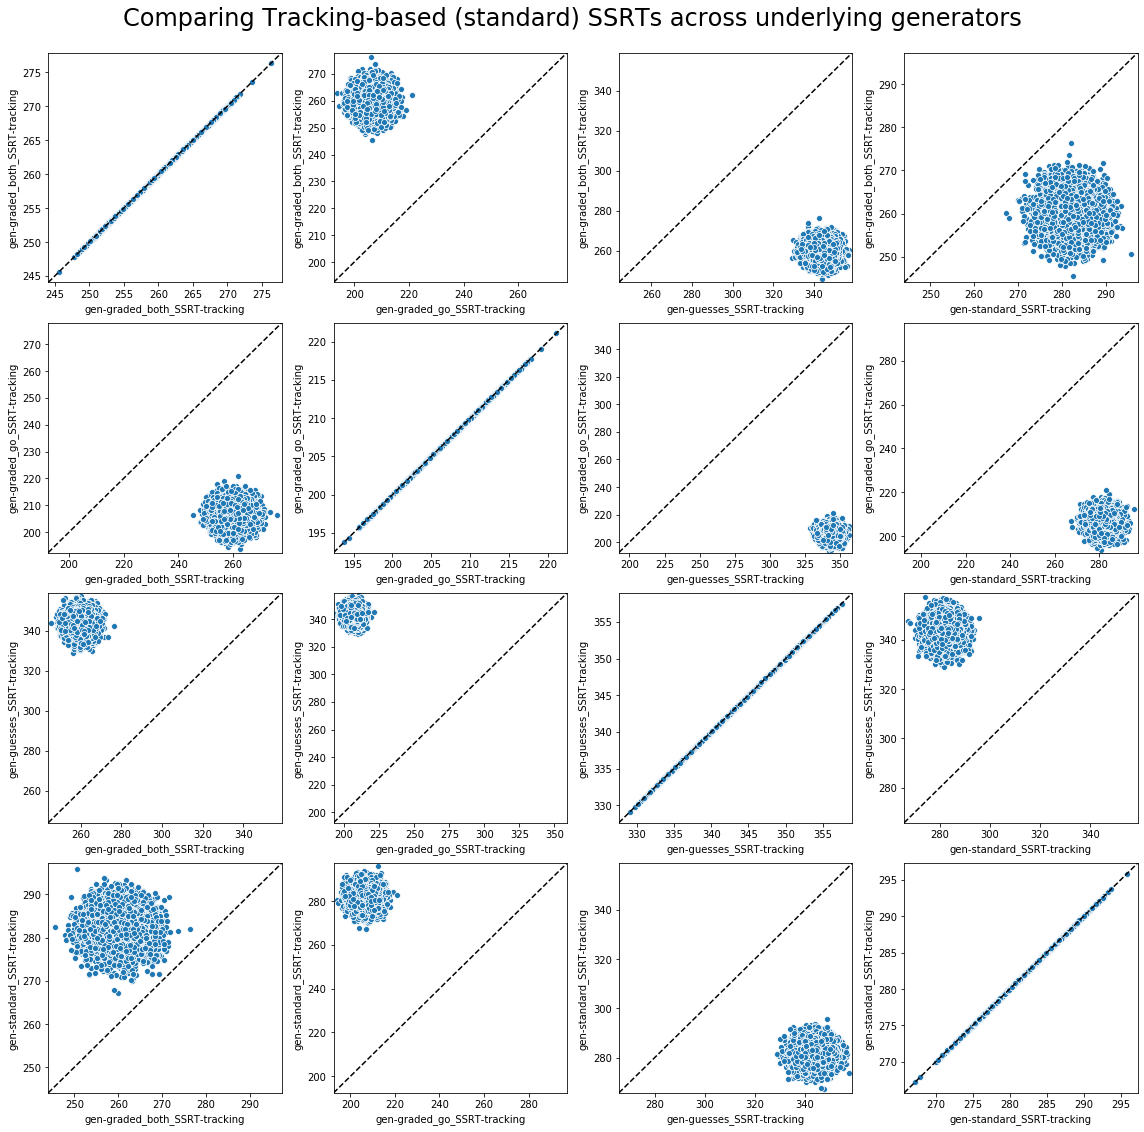

In [22]:
curr_df = monster_df.filter(regex='SSRT-tracking')

fig, axes = plt.subplots(4, 4, figsize=(16,16))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
        ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [23]:
curr_df.corr(method='spearman')

,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking,gen-guesses_SSRT-tracking,gen-standard_SSRT-tracking
gen-graded_both_SSRT-tracking,1.000000,-0.013635,-0.002153,-0.016897
gen-graded_go_SSRT-tracking,-0.013635,1.000000,-0.011719,0.011951
gen-guesses_SSRT-tracking,-0.002153,-0.011719,1.000000,0.009942
gen-standard_SSRT-tracking,-0.016897,0.011951,0.009942,1.000000


## not rescaling axes

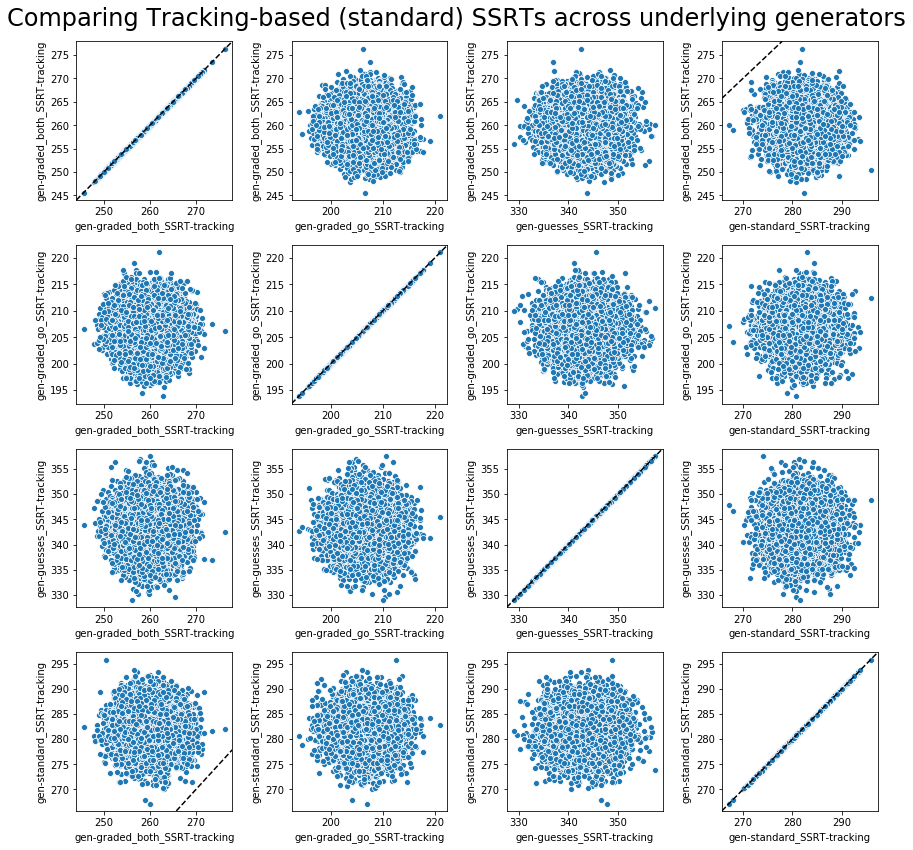

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))

for idx,coli in enumerate(curr_df.columns):
    for jdx, colj in enumerate(curr_df.columns):
        ax = sns.scatterplot(x=colj, y=coli, data=curr_df, ax=axes[idx, jdx])
#         ax = make_plot_square(ax)
        _ = add_identity(ax, color='k', ls='--')
_ = fig.suptitle('Comparing Tracking-based (standard) SSRTs across underlying generators', fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [25]:
main_cols = ['assigned_SSRT',
             'gen-graded_both_SSRT-standard',
             'gen-graded_go_SSRT-standard',
             'gen-guesses_SSRT-standard',
             'gen-standard_SSRT-standard',
             'gen-graded_both_SSRT-fixed',
             'gen-graded_go_SSRT-fixed',
             'gen-guesses_SSRT-fixed',
             'gen-standard_SSRT-fixed',
             'gen-graded_both_SSRT-tracking',
             'gen-graded_go_SSRT-tracking',
             'gen-guesses_SSRT-tracking',
             'gen-standard_SSRT-tracking']
monster_df[main_cols].describe()

,assigned_SSRT,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard,gen-guesses_SSRT-standard,gen-standard_SSRT-standard,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed,gen-guesses_SSRT-fixed,gen-standard_SSRT-fixed,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking,gen-guesses_SSRT-tracking,gen-standard_SSRT-tracking
count,8.238000e+03,8238.000000,8237.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000,8238.000000
mean,3.013400e+02,279.839650,215.200611,323.549712,288.567903,279.685482,214.598446,336.595776,287.778344,259.886483,206.802889,343.193796,281.838552
std,8.299643e-12,36.245397,9.663436,28.493773,7.405720,3.296303,2.890240,3.775829,3.385500,3.714500,3.360564,3.841473,3.491363
min,3.013400e+02,235.916667,184.966667,270.938776,261.326531,267.000000,204.000000,322.000000,277.000000,245.590000,193.806000,329.060000,267.194000
25%,3.013400e+02,255.528070,208.166667,301.070833,283.533333,277.000000,213.000000,334.000000,285.000000,257.354000,204.570000,340.642500,279.458500
50%,3.013400e+02,264.327684,212.750000,315.386582,287.800000,280.000000,215.000000,337.000000,288.000000,259.918000,206.822000,343.158000,281.822000
75%,3.013400e+02,292.354167,220.613636,341.295833,293.016667,282.000000,217.000000,339.000000,290.000000,262.365500,209.053500,345.793500,284.183500
max,3.013400e+02,450.933333,264.452381,412.000000,316.200000,291.000000,226.000000,349.000000,303.000000,276.328000,221.062000,357.482000,295.802000


In [26]:
ssrt_df.corr(method='spearman')

,gen-graded_both_SSRT-standard,gen-graded_go_SSRT-standard.1,gen-guesses_SSRT-standard.2,gen-standard_SSRT-standard.3,gen-graded_both_SSRT-guesses,gen-graded_go_SSRT-guesses.1,gen-guesses_SSRT-guesses.2,gen-standard_SSRT-guesses.3,gen-graded_both_SSRT-graded_go,gen-graded_go_SSRT-graded_go.1,...,gen-guesses_SSRT-graded_both.2,gen-standard_SSRT-graded_both.3,gen-graded_both_SSRT-fixed,gen-graded_go_SSRT-fixed.1,gen-guesses_SSRT-fixed.2,gen-standard_SSRT-fixed.3,gen-graded_both_SSRT-tracking,gen-graded_go_SSRT-tracking.1,gen-guesses_SSRT-tracking.2,gen-standard_SSRT-tracking.3
gen-graded_both_SSRT-standard,1.000000,-0.698377,0.880411,0.732705,0.454266,-0.866096,0.518480,-0.877672,0.909518,0.756697,...,0.888168,0.871074,0.132239,0.004982,0.003167,0.012447,-0.002431,-0.000267,0.014505,0.013119
gen-graded_go_SSRT-standard.1,-0.698377,1.000000,-0.844545,-0.641284,0.035928,0.906539,-0.484569,0.832505,-0.832320,-0.663025,...,-0.860953,-0.874419,0.011037,0.220125,-0.002030,0.002114,0.003854,0.008772,-0.000338,0.003160
gen-guesses_SSRT-standard.2,0.880411,-0.844545,1.000000,0.753997,0.167107,-0.969879,0.700628,-0.948485,0.961620,0.831861,...,0.976345,0.968089,-0.011094,0.006509,0.119964,0.004766,-0.006326,-0.005712,0.005734,0.011765
gen-standard_SSRT-standard.3,0.732705,-0.641284,0.753997,1.000000,0.297954,-0.761129,0.453867,-0.625164,0.760296,0.652367,...,0.763698,0.784090,-0.008766,0.013525,0.005271,0.353255,-0.005064,0.006606,0.008778,0.007490
gen-graded_both_SSRT-guesses,0.454266,0.035928,0.167107,0.297954,1.000000,-0.124717,0.187697,-0.174811,0.223715,0.101572,...,0.168937,0.148203,0.199288,-0.006349,0.000992,0.015109,-0.014139,0.008477,0.004457,0.018830
gen-graded_go_SSRT-guesses.1,-0.866096,0.906539,-0.969879,-0.761129,-0.124717,1.000000,-0.555090,0.959553,-0.973641,-0.826662,...,-0.989335,-0.990563,0.014033,0.029361,-0.002579,-0.005162,-0.000620,0.004994,-0.004852,-0.007543
gen-guesses_SSRT-guesses.2,0.518480,-0.484569,0.700628,0.453867,0.187697,-0.555090,1.000000,-0.545175,0.545727,0.469197,...,0.571445,0.553109,-0.005473,-0.007772,0.491935,0.002044,-0.035710,-0.010430,0.001656,0.024930
gen-standard_SSRT-guesses.3,-0.877672,0.832505,-0.948485,-0.625164,-0.174811,0.959553,-0.545175,1.000000,-0.950947,-0.828858,...,-0.961344,-0.947242,0.012031,-0.006836,0.001501,0.104696,-0.004215,0.006822,-0.007155,-0.011307
gen-graded_both_SSRT-graded_go,0.909518,-0.832320,0.961620,0.760296,0.223715,-0.973641,0.545727,-0.950947,1.000000,0.835664,...,0.992137,0.982571,-0.002220,0.007768,0.005134,0.008115,0.003400,-0.002043,0.006344,0.009688
gen-graded_go_SSRT-graded_go.1,0.756697,-0.663025,0.831861,0.652367,0.101572,-0.826662,0.469197,-0.828858,0.835664,1.000000,...,0.847036,0.852256,-0.007381,0.106855,0.005976,-0.001114,0.004996,-0.013535,0.005685,0.005974


## How many subs survived (i.e. didn't have non-null SSRTs)

This can occur during the weighted method if one of their SSD-specific SSRTs is null. Not sure if you want me to fix.

In [27]:
monster_df.columns

options = ['standard', 'guesses', 'graded_go', 'graded_both']

for gen_str in options:
    for ssrt_str in options:
        col = 'gen-%s_SSRT-%s' % (gen_str, ssrt_str)
        print(col, len(monster_df.loc[monster_df[col].notnull()]))

gen-standard_SSRT-standard 8238
gen-standard_SSRT-guesses 8238
gen-standard_SSRT-graded_go 8238
gen-standard_SSRT-graded_both 8238
gen-guesses_SSRT-standard 8238
gen-guesses_SSRT-guesses 8238
gen-guesses_SSRT-graded_go 8238
gen-guesses_SSRT-graded_both 8238
gen-graded_go_SSRT-standard 8237
gen-graded_go_SSRT-guesses 8237
gen-graded_go_SSRT-graded_go 8237
gen-graded_go_SSRT-graded_both 8237
gen-graded_both_SSRT-standard 8238
gen-graded_both_SSRT-guesses 8238
gen-graded_both_SSRT-graded_go 8238
gen-graded_both_SSRT-graded_both 8238


# Plot graded Mu Go function

In [28]:
SSDs = np.arange(0,650, 5)

simulator = SimulateData()
mu_gos = [[i, simulator._log_grade_mu(1, i)] for i in SSDs]

/Users/henrymj/Documents/ABCD_simulations/scripts/utils.py:342: RuntimeWarning: divide by zero encountered in log
  return self._at_least_0((np.log(SSD/max_SSD)/4+1) * mu_go)


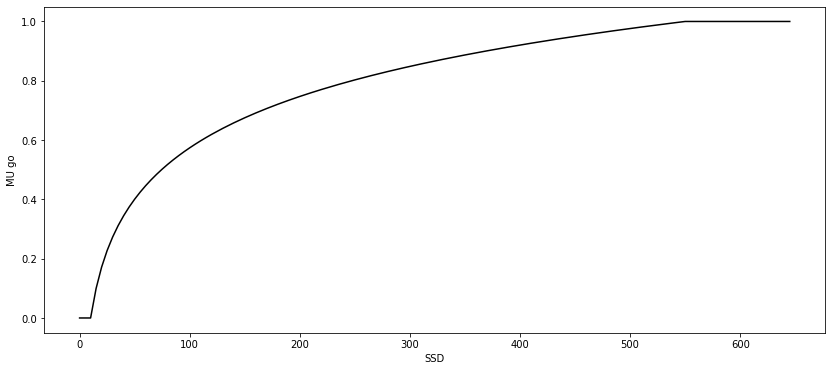

In [29]:
fig,ax = plt.subplots(1,1, figsize=(14, 6))

_ = sns.lineplot(x='SSD', y='MU go', color='k', data=pd.DataFrame(mu_gos, columns=['SSD', 'MU go']))
plt.savefig('figures/graded_mu_go_function.png')